<a href="https://colab.research.google.com/github/p-tech/BDAI-Files/blob/main/Topic%20Modelling%20-%20Google%20ADs%20-%20Search%20Terms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Topic Modelling for review analysis**

Latent Dirichlet Allocation (LDA) is a classic model to do topic modelling. Topic modeling is unsupervised learning and the goal is to group different documents to the same “topic”.

## **1. import data you would like to analyse**

In [ ]:
# Let's import data first
# Run the code and upload the csv file from your laptop
from google.colab import files
uploaded = files.upload()

Saving Search terms report (2).csv to Search terms report (2).csv


In [ ]:
import pandas as pd

data = 'Search.csv'
df = pd.read_csv(data) # change the csv file name to your file name that you uploaded
df.head()

,Search terms report
0,"December 23, 2024 - January 19, 2025"
1,Search term
2,serene holidays leicester
3,coach holidays to barmouth
4,last minute coach holidays in the uk


In [ ]:
target_column = 'Search terms report' #change the column name to where the review is

## **2. Text cleaning & Text processing**
Before you do topic modeling, you need make sure you clean and process the text.

In [ ]:
!pip install contractions
import re
import string
import contractions
import nltk
import gensim
from gensim.utils import simple_preprocess
import spacy
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


# drop data with missing values in the 'content' column
df = df.dropna(subset=[target_column])

# drop duplicate review content
df = df.drop_duplicates(subset=[target_column])

# remove contraction
df[target_column] = df[target_column].map(lambda x: contractions.fix(x))

# convert the relevant column to lowercase
df[target_column] = df[target_column].str.lower()

# Remove overspace
df[target_column] = df[target_column].map(lambda x: re.sub('\s{2,}', " ", x))

# Remove non-word characters, so numbers and ___ etc
df[target_column] = df[target_column].str.replace("[^A-Za-z]", " ", regex = True)

# Remove punctuation
df[target_column] = df[target_column].map(lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 8.4 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# create a list of the contents from the 'contents' column
words = df[target_column].tolist()

# tokenise the words
word_tokens = []
for content in words:
    word_tokens.append(word_tokenize(content))

# create bigram model
bigram = gensim.models.phrases.Phrases(word_tokens, min_count=3, threshold=10)
bigram_mod = gensim.models.phrases.Phraser(bigram) # Faster way to get a sentence clubbed as a trigram/bigram

# NLTK Stop words
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['app']) #add more stopwords here

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Define functions for stopwords, bigrams and lemmatisation
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove stopwords
data_words_nostops = remove_stopwords(word_tokens)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Do lemmatisation keeping only noun, adj, vb, adv
data_lemmatised = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# put the tokens back together as text to have our filtered contents

rejoin = []
for content in data_lemmatised: # Here we choose to use stemming instead of lemmatisation
    x = " ".join(content) # join the text back together
    rejoin.append(x)

# add the reformed text to the data frame
df['cleaned_review'] = rejoin

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df.head()

,Search terms report,cleaned_review
0,december january,
1,search term,search term
2,serene holidays leicester,serene holiday leicester
3,coach holidays to barmouth,coach holiday
4,last minute coach holidays in the uk,last_minute coach holiday


## **3. Build the LDA model**

In [ ]:
# vectorise the data into word counts

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

max_words = 1000 #how many words taking account for topic modeling
vectorizer = CountVectorizer(max_features=max_words)
vec = vectorizer.fit_transform(df['cleaned_review'])

k = 6 #this is the number of the topic. you can decide the number

lda = LDA(n_components=k, max_iter=5, learning_method='online', random_state = 10)
lda.fit(vec)

LatentDirichletAllocation(learning_method='online', max_iter=5, n_components=6,
                          random_state=10)

## **4. Visualisation of the topics**

Topic#  1
good,glen,com,footstep,hotel,term,search,glasgow,total,liverpool,alfatravel,southend,international,coldfield,johnsonscoache,castle,highclere,hire,perry,edinburgh,lochs,stage,folkestone,rise,pdf,adelphi,adam,soleil,cirque,holidaypirate,justgoholiday,fenn,oxford,cricket,beatle,rabbie,margate,world,gardener,live,ridley,seasider,clicktrip,sea,dunwoody,robertsholiday,studio,hamilton,wickson,coalville

Topic#  2
bus,wight,coventry,national,weekend_break,harry_shaw,www,express,line,derby,pullman,brother,co_uk,seaside,transportation,green,late,chaserider,account,beehive,wilfreda,total,chuckle,babbacombe,country,hospital,date,parry,bayliss,group,barking,disney,carmarthen,coracle,deal,tee,southall,donegal,leominster,shire,northampton,marylebone,lux,peterborough,settle,railway,zante,road,dunwoodtravel,leed

Topic#  3
trip,coach,day,weekend,scotland,short_break,wale,walsall,dunwood_travel,midland,worcester,marchant,local,stourbridge,kidderminster,whittles,show,greenline,redditch,normandy

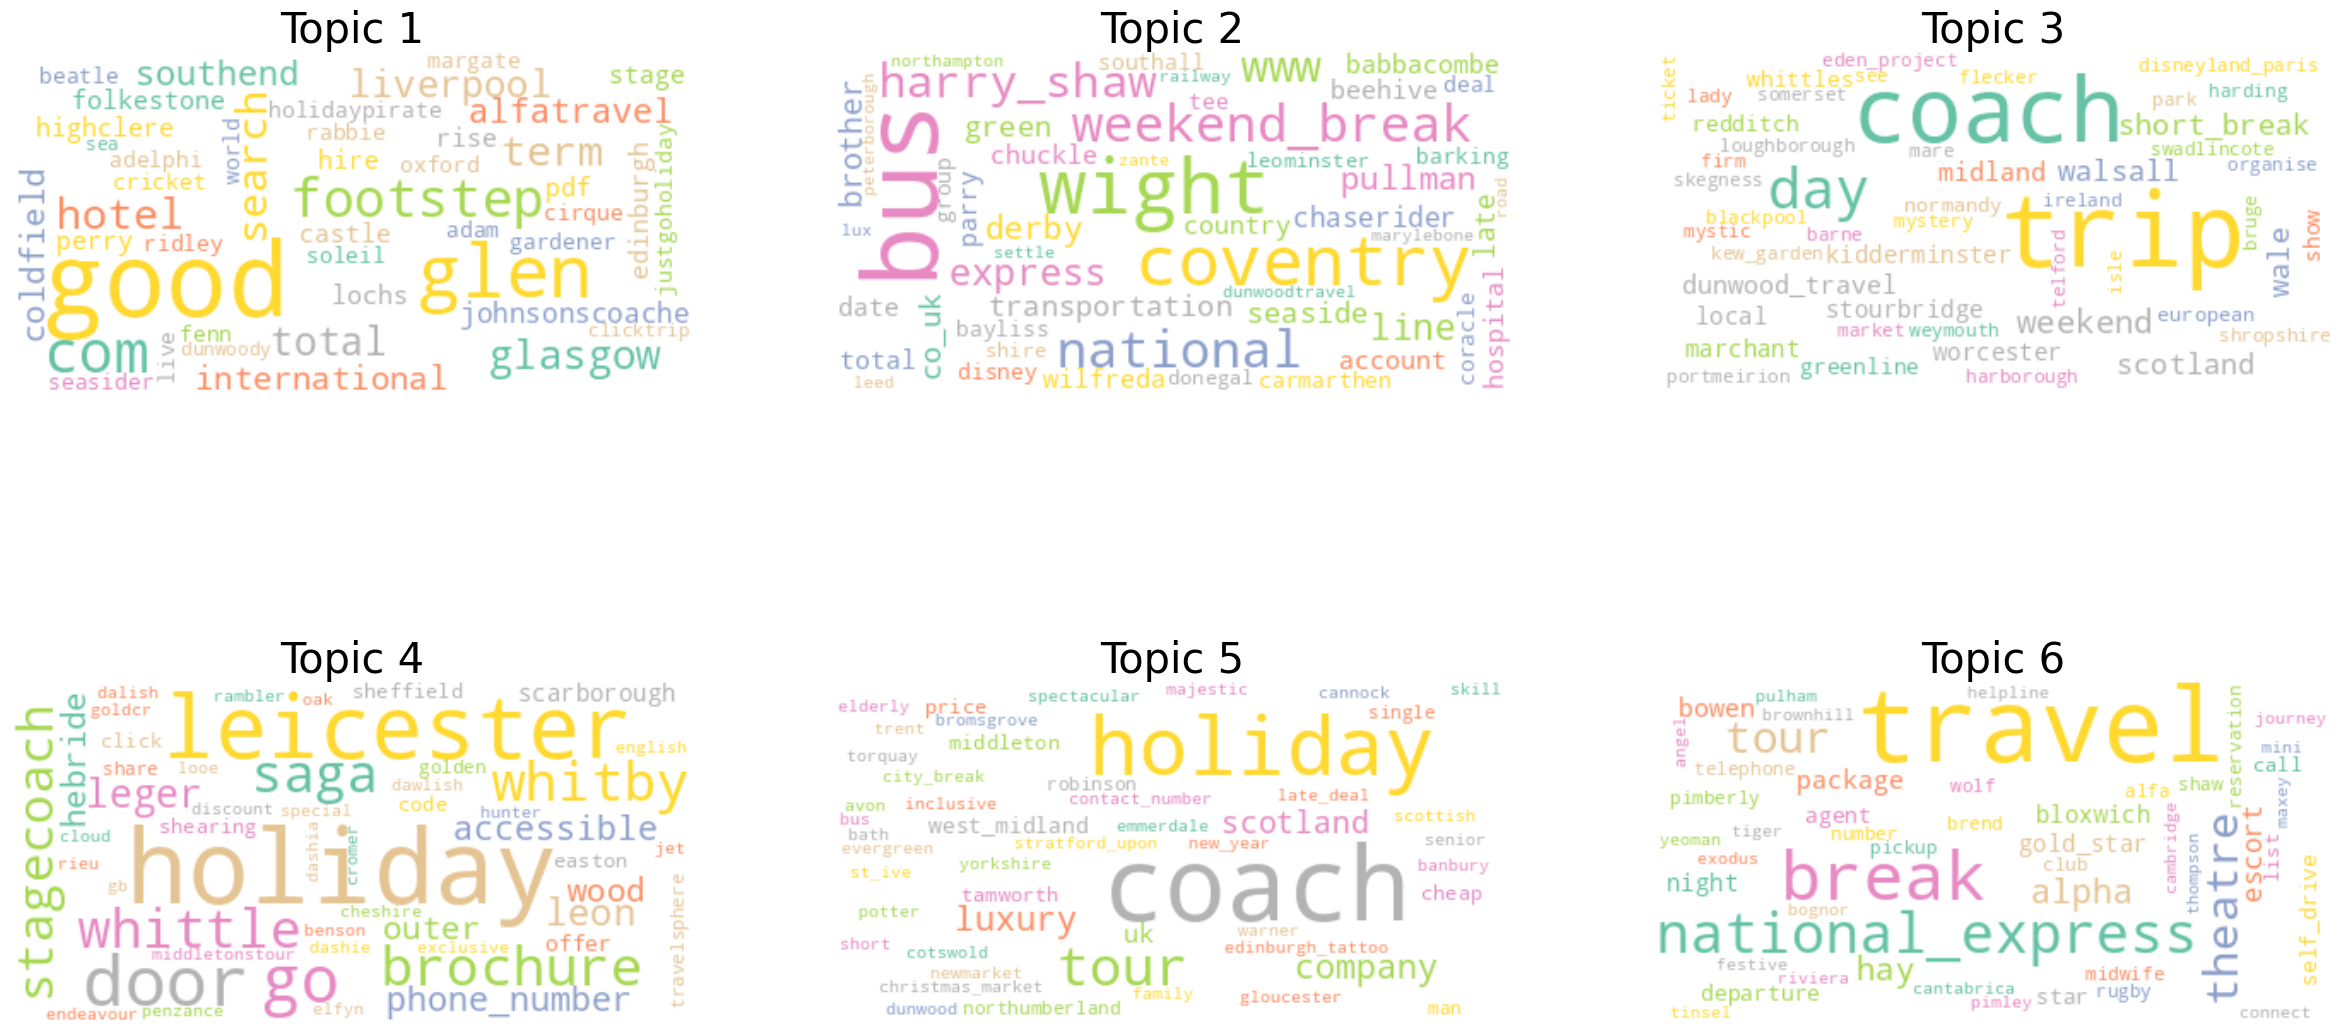

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import wordcloud

#declaring number of terms we need per topic
terms_count = 50

terms = vectorizer.get_feature_names_out()

wcloud = wordcloud.WordCloud(background_color="White",mask=None, max_words=100,\
                             max_font_size=60,min_font_size=10,prefer_horizontal=0.9,
                             contour_width=3,contour_color='Black',colormap='Set2')

fig, axes = plt.subplots(2, 3, figsize=(30, 15), sharex=True)
axes = axes.flatten()

for idx,topic in enumerate(lda.components_):
    print('Topic# ',idx+1)
    abs_topic = abs(topic)
    topic_terms = [[terms[i],topic[i]] for i in abs_topic.argsort()[:-terms_count-1:-1]]
    topic_terms_sorted = [[terms[i], topic[i]] for i in abs_topic.argsort()[:-terms_count - 1:-1]]
    topic_words = []
    for i in range(terms_count):
        topic_words.append(topic_terms_sorted[i][0])
    print(','.join( word for word in topic_words))
    print("")
    dict_word_frequency = {}

    for i in range(terms_count):
        dict_word_frequency[topic_terms_sorted[i][0]] = topic_terms_sorted[i][1]

    ax = axes[idx]
    ax.set_title(f'Topic {idx +1}',fontdict={'fontsize': 30})
    wcloud.generate_from_frequencies(dict_word_frequency)
    ax.imshow(wcloud, interpolation='bilinear')
    ax.axis("off")

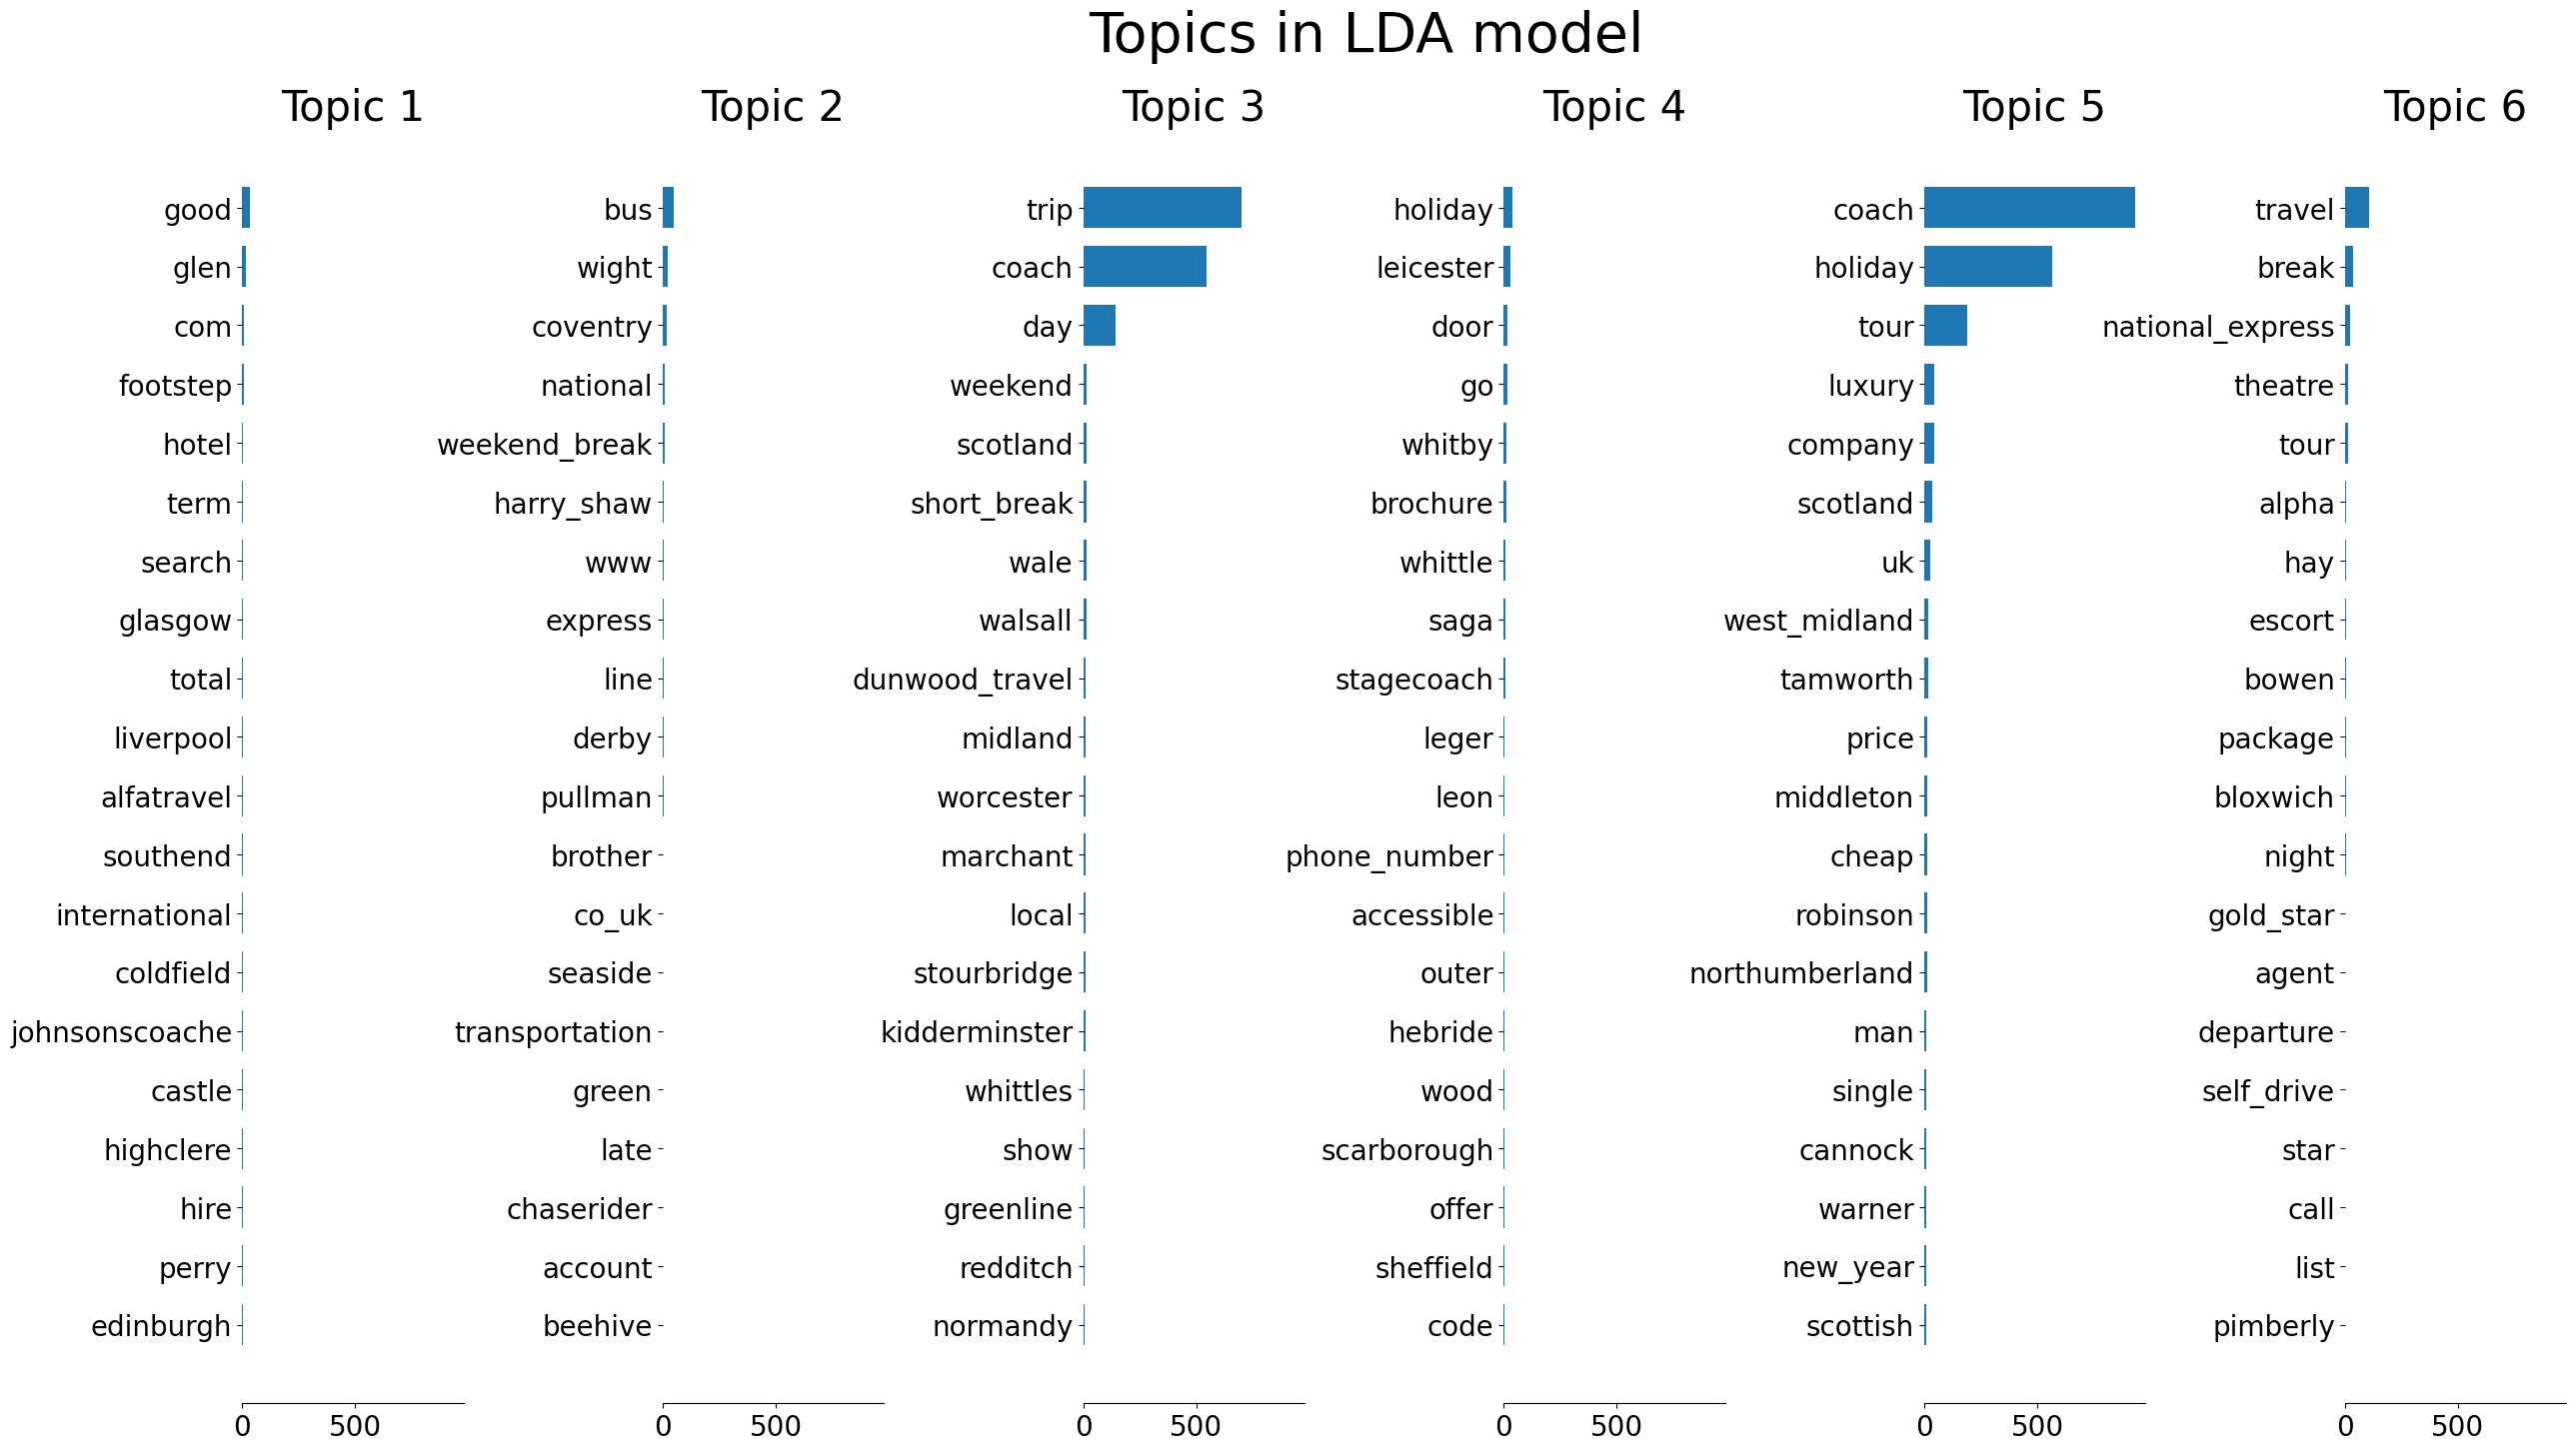

In [ ]:
# Visualise the result into bar charts in topic

%matplotlib inline
import matplotlib.pyplot as plt

# helper function to plot topics
# see Grisel et al.
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 6, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 20  #how many words to be visualised in each topic

# get the list of words (feature names)
vec_feature_names = vectorizer.get_feature_names_out()

# print the top words per topic
plot_top_words(lda, vec_feature_names, n_top_words, 'Topics in LDA model')

## **5. Download file with assigned topic**

In [ ]:
doc_topic = lda.transform(vec)
docsVStopics = pd.DataFrame(doc_topic, columns=["Topic"+str(i+1) for i in range(k)])
df = df.join(docsVStopics)
df['mostlikely_topic'] = docsVStopics.idxmax(axis=1)

df.to_csv('topic_modeling_result.csv', index=False) # save the file to google drive
files.download('topic_modeling_result.csv') # download the file to your local machine

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>